Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

from kaggle_datasets import KaggleDatasets

# Check for TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    # Check for GPU
    if tf.config.list_physical_devices('GPU'):
        print('Running on GPU')
        strategy = tf.distribute.MirroredStrategy()
    else:
        # Default strategy for CPU
        print('Running on CPU')
        strategy = tf.distribute.get_strategy()

print('Number of accelerators:', strategy.num_replicas_in_sync)


Running on GPU
Number of accelerators: 2


Load and Prepare the Dataset

In [2]:
AUTOTUNE = tf.data.AUTOTUNE

# Get the GCS path for the dataset
GCS_PATH = KaggleDatasets().get_gcs_path()

# File paths for Monet and photo TFRecords
monet_files = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
photo_files = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

print('Monet TFRecord files:', len(monet_files))
print('Photo TFRecord files:', len(photo_files))


Monet TFRecord files: 5
Photo TFRecord files: 20


Define functions to parse the TFRecords and preprocess the images.

In [3]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string),  # Change from tf.int64 to tf.string
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    # Read TFRecords and parse into images
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset


Load and batch the datasets

In [4]:
monet_dataset = load_dataset(monet_files).batch(1)
photo_dataset = load_dataset(photo_files).batch(1)


Visualize the Data

Monet Paintings


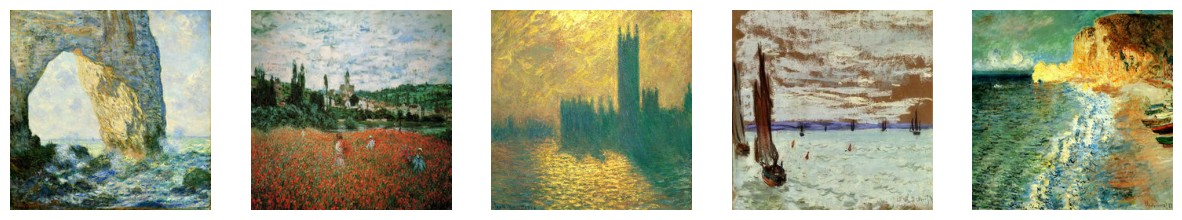

Photos


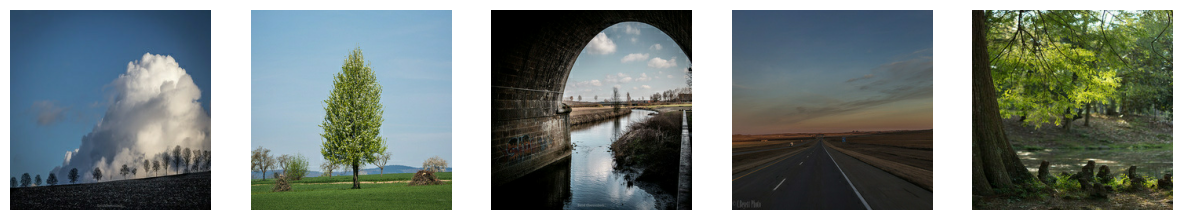

In [5]:
# Function to display sample images
def display_samples(dataset, n_samples):
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(dataset.take(n_samples)):
        plt.subplot(1, n_samples, i+1)
        plt.imshow((image[0] * 0.5) + 0.5)
        plt.axis('off')
    plt.show()

print('Monet Paintings')
display_samples(monet_dataset, 5)

print('Photos')
display_samples(photo_dataset, 5)


Build the Generator and Discriminator Models

In [6]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    block = keras.Sequential()
    block.add(layers.Conv2D(filters, size, strides=2, padding='same',
                            kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        block.add(layers.BatchNormalization())
    block.add(layers.LeakyReLU())
    return block

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    block = keras.Sequential()
    block.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                     kernel_initializer=initializer, use_bias=False))
    block.add(layers.BatchNormalization())
    if apply_dropout:
        block.add(layers.Dropout(0.5))
    block.add(layers.ReLU())
    return block


Build the Generator

In [7]:
def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Encoder: Downsampling layers
    down_layers = [
        downsample(64, 4, apply_norm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),                   # (bs, 64, 64, 128)
        downsample(256, 4),                   # (bs, 32, 32, 256)
        downsample(512, 4),                   # (bs, 16, 16, 512)
        downsample(512, 4),                   # (bs, 8, 8, 512)
        downsample(512, 4),                   # (bs, 4, 4, 512)
        downsample(512, 4),                   # (bs, 2, 2, 512)
        downsample(512, 4),                   # (bs, 1, 1, 512)
    ]

    # Decoder: Upsampling layers
    up_layers = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4),                     # (bs, 16, 16, 1024)
        upsample(256, 4),                     # (bs, 32, 32, 512)
        upsample(128, 4),                     # (bs, 64, 64, 256)
        upsample(64, 4),                      # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                     kernel_initializer=initializer,
                                     activation='tanh')  # (bs, 256, 256, 3)

    # Connect the layers
    x = inputs
    skips = []
    for down in down_layers:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_layers, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = outputs(x)
    return keras.Model(inputs=inputs, outputs=x)


Discriminator Model

In [8]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp
    x = downsample(64, 4, apply_norm=False)(x)  # (bs, 128, 128, 64)
    x = downsample(128, 4)(x)                   # (bs, 64, 64, 128)
    x = downsample(256, 4)(x)                   # (bs, 32, 32, 256)
    x = downsample(512, 4)(x)                   # (bs, 16, 16, 512)
    x = layers.ZeroPadding2D()(x)               # (bs, 18, 18, 512)
    x = layers.Conv2D(512, 4, strides=1,
                      kernel_initializer=initializer,
                      use_bias=False)(x)        # (bs, 15, 15, 512)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x)               # (bs, 17, 17, 512)
    x = layers.Conv2D(1, 4, strides=1,
                      kernel_initializer=initializer)(x)  # (bs, 14, 14, 1)
    return keras.Model(inputs=inp, outputs=x)


Define the CycleGAN Model

In [9]:
class CycleGAN(keras.Model):
    def __init__(self, generator_G, generator_F, discriminator_X, discriminator_Y, lambda_cycle=10.0):
        super(CycleGAN, self).__init__()
        self.generator_G = generator_G  # Photo to Monet
        self.generator_F = generator_F  # Monet to Photo
        self.discriminator_X = discriminator_X  # Discriminator for Photos
        self.discriminator_Y = discriminator_Y  # Discriminator for Monet paintings
        self.lambda_cycle = lambda_cycle

    def compile(self, gen_G_optimizer, gen_F_optimizer,
                disc_X_optimizer, disc_Y_optimizer,
                gen_loss_fn, disc_loss_fn,
                cycle_loss_fn, identity_loss_fn):
        super(CycleGAN, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_x, real_y = batch_data  # real_x: photos, real_y: Monet paintings

        with tf.GradientTape(persistent=True) as tape:
            # Generate fake images
            fake_y = self.generator_G(real_x, training=True)  # Photo to Monet
            cycled_x = self.generator_F(fake_y, training=True)  # Monet back to Photo

            fake_x = self.generator_F(real_y, training=True)  # Monet to Photo
            cycled_y = self.generator_G(fake_x, training=True)  # Photo back to Monet

            # Identity mapping
            same_x = self.generator_F(real_x, training=True)
            same_y = self.generator_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.discriminator_X(real_x, training=True)
            disc_real_y = self.discriminator_Y(real_y, training=True)

            disc_fake_x = self.discriminator_X(fake_x, training=True)
            disc_fake_y = self.discriminator_Y(fake_y, training=True)

            # Calculate losses
            gen_G_loss = self.gen_loss_fn(disc_fake_y)
            gen_F_loss = self.gen_loss_fn(disc_fake_x)

            total_cycle_loss = self.cycle_loss_fn(real_x, cycled_x, self.lambda_cycle) + \
                               self.cycle_loss_fn(real_y, cycled_y, self.lambda_cycle)

            id_loss_X = self.identity_loss_fn(real_x, same_x, self.lambda_cycle)
            id_loss_Y = self.identity_loss_fn(real_y, same_y, self.lambda_cycle)

            total_gen_G_loss = gen_G_loss + total_cycle_loss + id_loss_Y
            total_gen_F_loss = gen_F_loss + total_cycle_loss + id_loss_X

            disc_X_loss = self.disc_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.disc_loss_fn(disc_real_y, disc_fake_y)

        # Calculate gradients
        grads_gen_G = tape.gradient(total_gen_G_loss, self.generator_G.trainable_variables)
        grads_gen_F = tape.gradient(total_gen_F_loss, self.generator_F.trainable_variables)

        grads_disc_X = tape.gradient(disc_X_loss, self.discriminator_X.trainable_variables)
        grads_disc_Y = tape.gradient(disc_Y_loss, self.discriminator_Y.trainable_variables)

        # Apply gradients
        self.gen_G_optimizer.apply_gradients(zip(grads_gen_G, self.generator_G.trainable_variables))
        self.gen_F_optimizer.apply_gradients(zip(grads_gen_F, self.generator_F.trainable_variables))

        self.disc_X_optimizer.apply_gradients(zip(grads_disc_X, self.discriminator_X.trainable_variables))
        self.disc_Y_optimizer.apply_gradients(zip(grads_disc_Y, self.discriminator_Y.trainable_variables))

        return {
            'G_loss': total_gen_G_loss,
            'F_loss': total_gen_F_loss,
            'D_X_loss': disc_X_loss,
            'D_Y_loss': disc_Y_loss,
        }


Define Loss Functions

In [10]:
with strategy.scope():
    # Binary Cross Entropy loss function
    loss_obj = keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

    def generator_loss(generated):
        return tf.reduce_mean(loss_obj(tf.ones_like(generated), generated))

    def discriminator_loss(real, generated):
        real_loss = loss_obj(tf.ones_like(real), real)
        generated_loss = loss_obj(tf.zeros_like(generated), generated)
        total_loss = real_loss + generated_loss
        return tf.reduce_mean(total_loss) * 0.5

    def calc_cycle_loss(real_image, cycled_image, lambda_cycle):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return lambda_cycle * loss

    def identity_loss(real_image, same_image, lambda_identity):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return lambda_identity * 0.5 * loss


Compile and Train the Model

In [11]:
with strategy.scope():
    monet_generator = build_generator()      # Generator G: Photo to Monet
    photo_generator = build_generator()      # Generator F: Monet to Photo
    monet_discriminator = build_discriminator()  # Discriminator Y
    photo_discriminator = build_discriminator()  # Discriminator X

with strategy.scope():
    gen_G_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
    gen_F_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_X_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_Y_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

with strategy.scope():
    cycle_gan_model = CycleGAN(generator_G=monet_generator, generator_F=photo_generator,
                               discriminator_X=photo_discriminator, discriminator_Y=monet_discriminator)

    cycle_gan_model.compile(
        gen_G_optimizer=gen_G_optimizer,
        gen_F_optimizer=gen_F_optimizer,
        disc_X_optimizer=disc_X_optimizer,
        disc_Y_optimizer=disc_Y_optimizer,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=calc_cycle_loss,
        identity_loss_fn=identity_loss
    )


Prepare the training dataset by zipping the photo and Monet datasets.

In [12]:
train_dataset = tf.data.Dataset.zip((photo_dataset, monet_dataset))

Train the model.

In [13]:
EPOCHS = 25

cycle_gan_model.fit(
    train_dataset,
    epochs=EPOCHS
)

Epoch 1/25


2024-11-28 23:56:02.708520: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_940/cond/StatefulPartitionedCall/functional_16_5/sequential_8_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 ━━━━━━━━━━━━━━━━━━━━ 284s 538ms/step - D_X_loss: nan - D_Y_loss: nan - F_loss: nan - G_loss: nan
Epoch 2/25


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 164s 545ms/step - D_X_loss: nan - D_Y_loss: nan - F_loss: nan - G_loss: nan
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 164s 545ms/step - D_X_loss: nan - D_Y_loss: nan - F_loss: nan - G_loss: nan
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 164s 546ms/step - D_X_loss: nan - D_Y_loss: nan - F_loss: nan - G_loss: nan
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 164s 545ms/step - D_X_loss: nan - D_Y_loss: nan - F_loss: nan - G_loss: nan
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 164s 545ms/step - D_X_loss: nan - D_Y_loss: nan - F_loss: nan - G_loss: nan
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 164s 544ms/step - D_X_loss: nan - D_Y_loss: nan - F_loss: nan - G_loss: nan
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 164s 544ms/step - D_X_loss: nan - D_Y_loss: nan - F_loss: nan - G_loss: nan
Epoch 9/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 164s 544ms/step - D_X_loss: nan - D_Y_loss: nan - F_loss: nan - G_loss: nan
Epoch 10/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 164s 545ms/step - D_X_loss: nan - D_Y_loss

Generate and Save Monet-style Images

In [14]:
import os
import PIL
from tqdm import tqdm

# Create a directory to save the images
os.makedirs('../images', exist_ok=True)

i = 1
for img in tqdm(photo_dataset, total=7000):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(f"../images/{i}.jpg")
    i += 1
    if i > 7000:  # Limit to 7000 images
        break


100%|█████████▉| 6999/7000 [05:15<00:00, 22.18it/s]


Compress the generated images into a zip file for submission.

In [15]:
import shutil

shutil.make_archive('images', 'zip', '../images')


'/kaggle/working/images.zip'